<a href="https://colab.research.google.com/github/habstrakT808/IMPLEMENTASI-RANDOM-FOREST-UNTUK-PREDIKSI-PENYAKIT-JANTUNG/blob/main/%5BTP%5D%5BPPM_TIF_C%5D_Hafiyan_Al_Muqaffi_Umary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Import library yang diperlukan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

#Load dataset

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
heart_data = pd.read_csv(url, names=names, na_values='?')

#Handling missing values


In [ ]:
heart_data = heart_data.dropna()

#Data preprocessing


In [ ]:
X = heart_data.drop('target', axis=1)
y = heart_data['target']
X_encoded = pd.get_dummies(X, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

#Binarize the output for ROC curve calculation

In [ ]:
y_train_bin = label_binarize(y_train, classes=[0, 1, 2, 3, 4])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

#Initialize RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

#Define grid parameters for GridSearchCV

In [ ]:
param_grid = {
'n_estimators': [100, 200, 300],
'max_depth': [None, 10, 20, 30],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
'max_features': ['sqrt', 'log2']
}

#Initialize GridSearchCV

In [ ]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

#Train model using GridSearchCV

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

#Print best parameters after tuning

In [ ]:
print("Best parameters after tuning:")
print(grid_search.best_params_)
print()

Best parameters after tuning:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}



#Predict using the best model

In [ ]:
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

#Evaluate model

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")
print()

print("Classification Report:")
print(classification_report(y_test, y_pred))
print()

Model accuracy: 0.60

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        36
           1       0.12      0.11      0.12         9
           2       0.20      0.20      0.20         5
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         3

    accuracy                           0.60        60
   macro avg       0.22      0.25      0.23        60
weighted avg       0.49      0.60      0.54        60




#Confusion Matrix

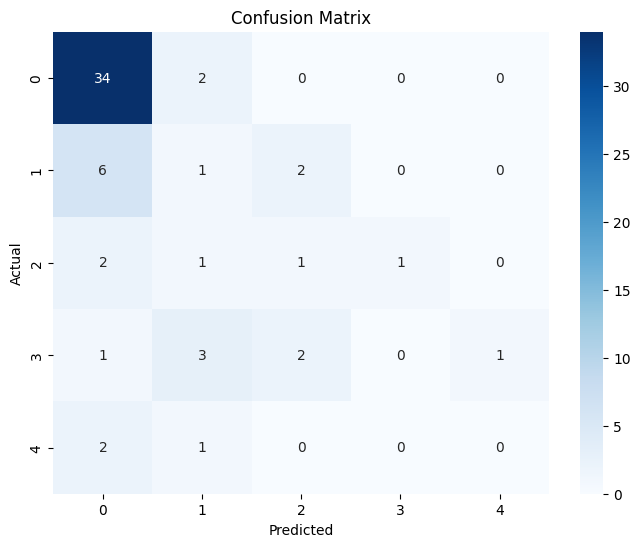

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#One-vs-Rest strategy for ROC and AUC

In [ ]:
ovr = OneVsRestClassifier(best_rf_model)
y_score = ovr.fit(X_train, y_train_bin).predict_proba(X_test)

#Compute ROC curve and ROC area for each class

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_train_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


#Plot ROC curve for each class

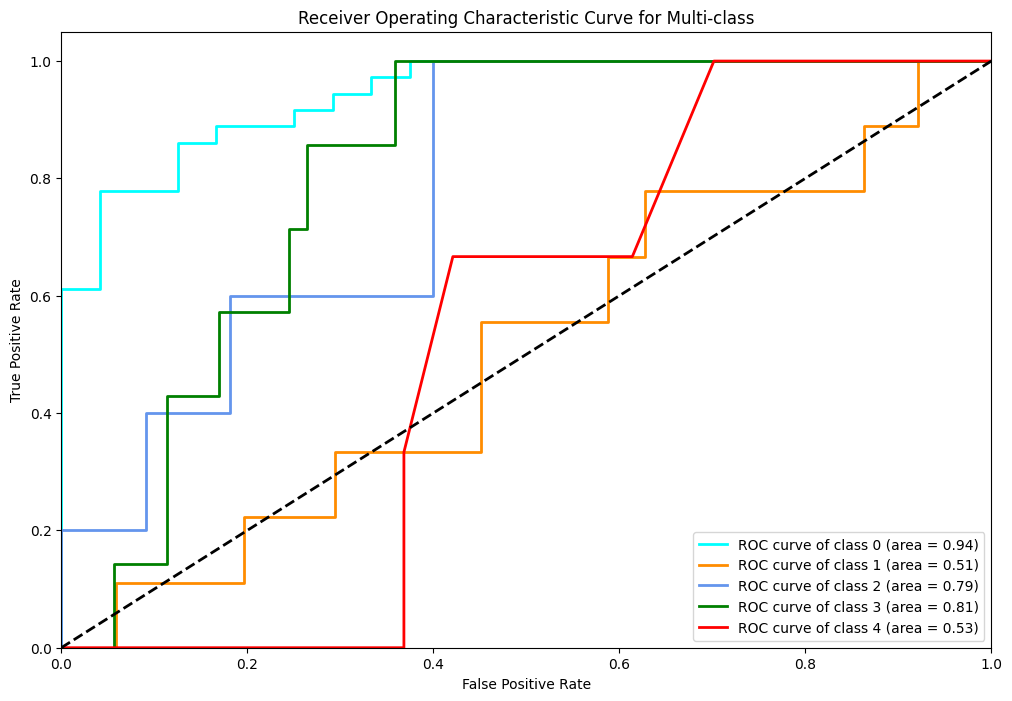

In [ ]:
# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(y_train_bin.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for Multi-class')
plt.legend(loc="lower right")
plt.show()
